# Import libraries

In [3]:
import numpy as np
import pandas as pd
from statsmodels.stats import stattools
from sklearn import *
import matplotlib.pyplot as plt
from scipy.optimize import *

# Include py file

In [2]:
from Denoising import *

# TESTING THE MARCENKO–PASTUR THEOREM

In [3]:
x = np.random.normal(size = (10000, 1000))
eval0, evec0 = PCA(np.corrcoef(x ,rowvar = 0))
pdf0 = marcenkoPasturPDF(1., q = x.shape[0]/float(x.shape[1]), pts=1000)
pdf1 = fitKDE(np.diag(eval0), bwidth=.01) # empirical pdf

In [4]:
var = 1
q = x.shape[0]/float(x.shape[1])
pts = 1000
emin, emax = var*(1 - (1./q)**.5)**2, var*(1 + (1./q)**.5)**2
eval = np.linspace(emin, emax, pts)

In [5]:
plt.figure(figsize = (7, 5), dpi = 80)
plt.plot(eval, pdf0)
plt.title("A visualization of the Marcenko–Pastur theorem")
plt.xlabel("λ")
plt.ylabel("prob[λ]")
plt.plot(eval, pdf1, color = 'orange', ls = 'dashed')
legend_drawn_flag = True
plt.legend(["Marcenko-Pastur", "Empirical:KDE"], loc = 0, frameon = legend_drawn_flag)
plt.show()

# ADD SIGNAL TO A RANDOM COVARIANCE MATRIX

In [6]:
alpha, ncols, nfact, q=.995, 1000, 100, 10
cov = np.cov(np.random.normal(size = (ncols*q, ncols)), rowvar = 0)
cov = alpha*cov + (1 - alpha)*randomCov(ncols, nfact) # noise+signal
corr0 = cov2Corr(cov)
eval0, evec0 = PCA(corr0)

# FITTING THE MARCENKO–PASTUR PDF

In [7]:
emax0, var0 = findMaxEval(np.diag(eval0), q, bwidth = .01)
nfacts0 = eval0.shape[0] - np.diag(eval0)[::-1].searchsorted(emax0)

In [8]:
nfacts0

100

In [9]:
var0

0.6783224838528369

# Denoising

## Constant Residual Eigenvalue Method

In [10]:
corr1 = denoisedCorr(eval0, evec0, nfacts0)
eval1 , evec1 = PCA(corr1)

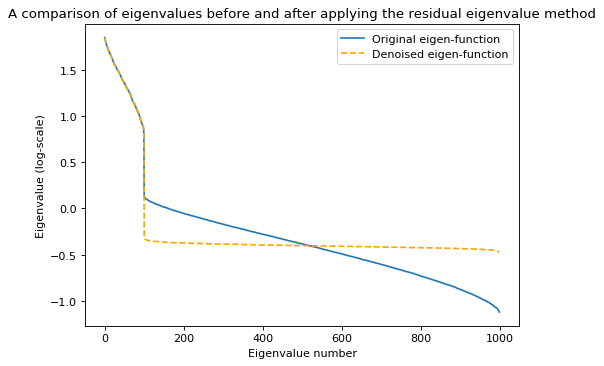

In [11]:
plt.figure(figsize = (7, 5), dpi = 80)
plt.plot(np.log(np.diag(eval0)))
plt.title("A comparison of eigenvalues before and after applying the residual eigenvalue method")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue (log-scale)")
plt.plot(np.log(np.diag(eval1)), color = 'orange', ls = 'dashed')
legend_drawn_flag = True
plt.legend(["Original eigen-function", "Denoised eigen-function"], loc = 0, frameon = legend_drawn_flag)
plt.show()

# Detoning

# DENOISING BY TARGETED SHRINKAG

In [12]:
corr1 = denoisedCorr2(eval0, evec0, nfacts0, alpha = .5)
eval1 , evec1 = PCA(corr1)

# GENERATING A BLOCK-DIAGONAL COVARIANCE MATRIX AND A VECTOR OF MEANS

In [13]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
nblocks, bsize, bcorr = 10, 50, .5
np.random.seed(0)
mu0, cov0 = formTrueMatrix(nblocks, bsize, bcorr)

# DENOISING OF THE EMPIRICAL COVARIANCE MATRIX

 # Minimum Variance Portfolio

In [14]:
nObs, ntrials, bwidth, shrink, min_var_portf = 100, 100, .01 , False, True
w1 = pd.DataFrame(columns = range(cov0.shape[0]), index = range(ntrials), dtype = float)
w1_d = w1.copy(deep = True)
np.random.seed(0)
for i in range(ntrials):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink = shrink)
    if min_var_portf: mu1 = None
    cov1_d = deNoiseCov(cov1, nObs*1./cov1.shape[1], bwidth)
    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()

# ROOT-MEAN-SQUARE ERRORS

In [15]:
w0 = optPort(cov0, None if min_var_portf else mu0)
w0 = np.repeat(w0.T, w1.shape[0], axis = 0)
rmsd = np.mean((w1 - w0).values.flatten()**2)**.5 # RMSE
rmsd_d = np.mean((w1_d - w0).values.flatten()**2)**.5 # RMSE
print (rmsd, rmsd_d)

9.41414251480946 0.0030867255700438067


# Maximum Sharpe Ratio Portfolio